In [1]:
from streamer import NIStreamer
import numpy as np
from utils import iplot

In [2]:
ni_streamer = NIStreamer()

In [3]:
TRIG_LINE = 'PXI_Trig0'
REF_CLK_LINE = 'PXI_Trig7'

In [11]:
# Availble cards:
# ao_name_list = ['PXI1Slot3', 'PXI1Slot5']
# mf_name_list = ['PXI1Slot4']
# do_name_list = ['PXI1Slot6', 'PXI1Slot7', 'PXI1Slot8', 'PXI1Slot9']

In [4]:
ao_name_list = ['PXI1Slot3', 'PXI1Slot5']
mf_name_list = ['PXI1Slot4']
do_name_list = ['PXI1Slot6', 'PXI1Slot7', 'PXI1Slot8', 'PXI1Slot9']

# =========================================================================
# Add all cards ===========================================================
# =========================================================================

ao_proxy_list = []
do_proxy_list = []
mf_proxy_list = []

# AO cards
for max_name in ao_name_list:
    ao_proxy_list.append(ni_streamer.add_ao_card(
        max_name=max_name, 
        samp_rate=1e6
    ))
    
# MF cards
for max_name in mf_name_list:
    mf_proxy_list.append(ni_streamer.add_ao_card(
        max_name=max_name, 
        samp_rate=1e6
    ))

# DO cards
for max_name in do_name_list:
    do_proxy_list.append(ni_streamer.add_do_card(
        max_name=max_name, 
        samp_rate=10e6
    ))
    
# =========================================================================
# Configure start trigger and reference/sample clock ======================
# =========================================================================

# Main card (always PXI1Slot3)
ao_proxy_list[0].cfg_start_trig(line=TRIG_LINE, export=True)
ao_proxy_list[0].cfg_ref_clk(line=REF_CLK_LINE, export=True)

# Secondary cards
if len(ao_proxy_list) > 1:
    for ao_card in ao_proxy_list[1:]:
        ao_card.cfg_start_trig(line=TRIG_LINE)
        ao_card.cfg_ref_clk(line=REF_CLK_LINE)
    
for mf_card in mf_proxy_list:
    mf_card.cfg_start_trig(line=TRIG_LINE)
    mf_card.cfg_ref_clk(line=REF_CLK_LINE)
    
for do_card in do_proxy_list:
    do_card.cfg_start_trig(line=TRIG_LINE)
    do_card.cfg_samp_clk_src(src=REF_CLK_LINE)
    
# =========================================================================
# Add all channels ========================================================
# =========================================================================

ao_bank = []
do_bank = []

for ao_card in ao_proxy_list:
    for chan_idx in range(8):
        ao_bank.append(
            ao_card.add_chan(chan_idx=4*chan_idx)
        )
    
for mf_card in mf_proxy_list:
    for chan_idx in range(4):
        ao_bank.append(
            mf_card.add_chan(chan_idx=chan_idx)
        )
    
for do_card in do_proxy_list:
    for port_idx in range(4):
        for line_idx in range(8):
            do_bank.append(do_card.add_chan(
                port_idx=port_idx,
                line_idx=line_idx
            ))
            
print(f'AO chan num: {len(ao_bank)}')
print(f'DO chan num: {len(do_bank)}')

AO chan num: 20
DO chan num: 128


In [5]:
ao_bank[0]

Channel ao0 on card PXI1Slot3

In [6]:
ao_bank[1]

Channel ao4 on card PXI1Slot3

In [37]:
%%time

ni_streamer.clear_edit_cache()

total_dur = 10.0e-3  # 10.0
instr_dur = 2e-6  # 10e-3
instr_num = int(total_dur // instr_dur)

buf = 1e-6  # 50e-6

# AO pulse settings
amp = 0.5
freq = 100e3

t = 0
for idx in range(instr_num):
    
    for ao_chan in ao_bank:
        ao_chan.sine(
            t=t, dur=instr_dur - buf,
            amp=amp, freq=freq
        )
    for do_chan in do_bank:
        do_chan.go_high(t=t)
        do_chan.go_low(t=t + instr_dur - buf)
        
    t += instr_dur
    
print(f'instr_num = {instr_num}')

instr_num = 5000
Wall time: 4.9 s


In [8]:
# Plot

chan_proxy_list = []
chan_proxy_list.extend(ao_bank[:1] + ao_bank[-1:])
chan_proxy_list.extend(do_bank[:1] + do_bank[-1:])

iplot(
    chan_list=chan_proxy_list,
    t_end=0.1,
    nsamps=1e5
)

In [38]:
%%time
ni_streamer.compile()

Wall time: 1.76 s


0.0099991

Parameters:
```Python
total_dur = 10.0
buf = 50e-6
```

10 ms (1e3 per chan) - Wall time: 277 ms 

1 ms (10e3 per chan) 
- Adding instructions - Wall time: 6.23 s
- Compile - Wall time: 3.34 s

0.5 ms (20e3 per chan) - gap between repetitions is about 28 ms
- Adding instructions - Wall time: 12.3 s
- Compile - Wall time: 7.44 s

0.1 ms (100e3 per chan) - gap between repetitions is about 30.5 ms
- Adding instructions - Wall time: 54.8 s
- Compile - Wall time: 40.6 s

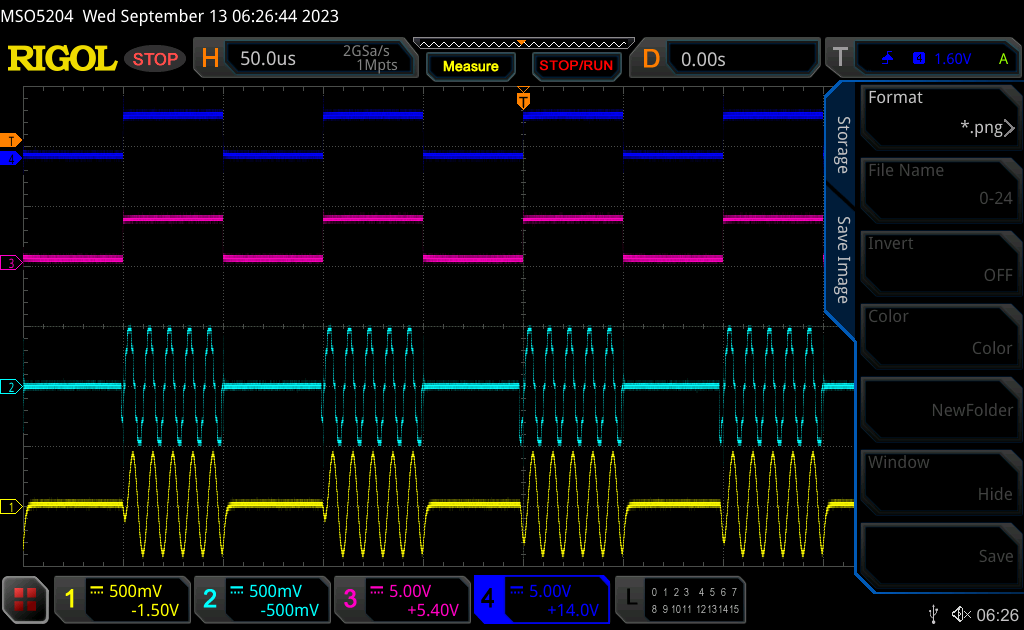

10 us - stable - gap between repetitions is about 14 ms

Used different parameters:
```Python
total_dur = 100e-3
buf = 5e-6
```


2 us intstruction duration, 1 us gap duration (effectively there is a new instruction every 1 us)

```Python
total_dur = 10.0e-3
instr_dur = 2e-6
instr_num = int(total_dur // instr_dur)
buf = 1e-6
```

Total 5000 instructions

- Adding instructions - Wall time: 4.9 s
- Compile - Wall time: 1.76 s

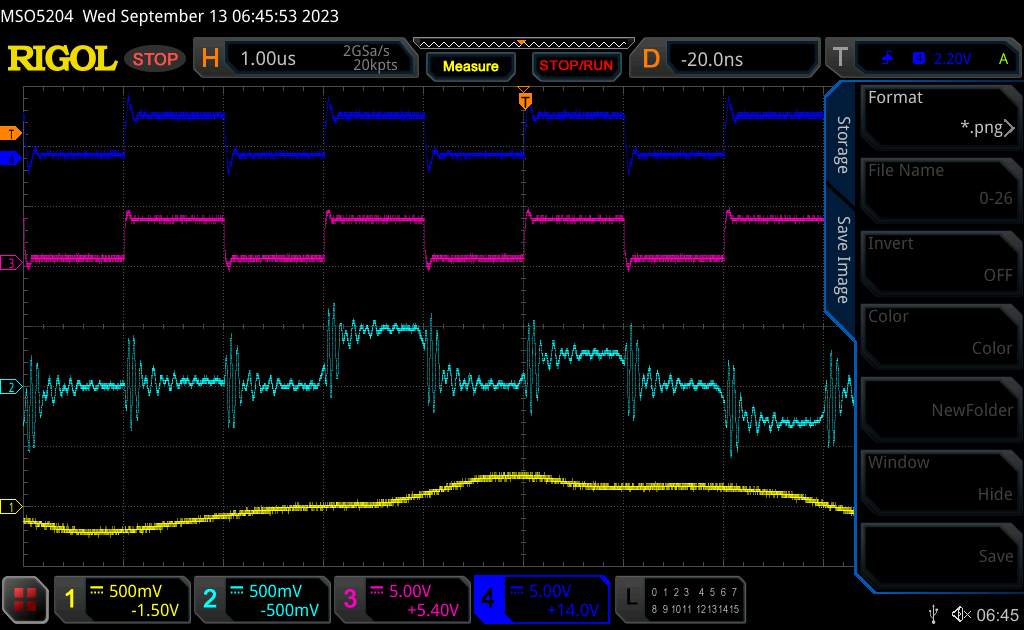

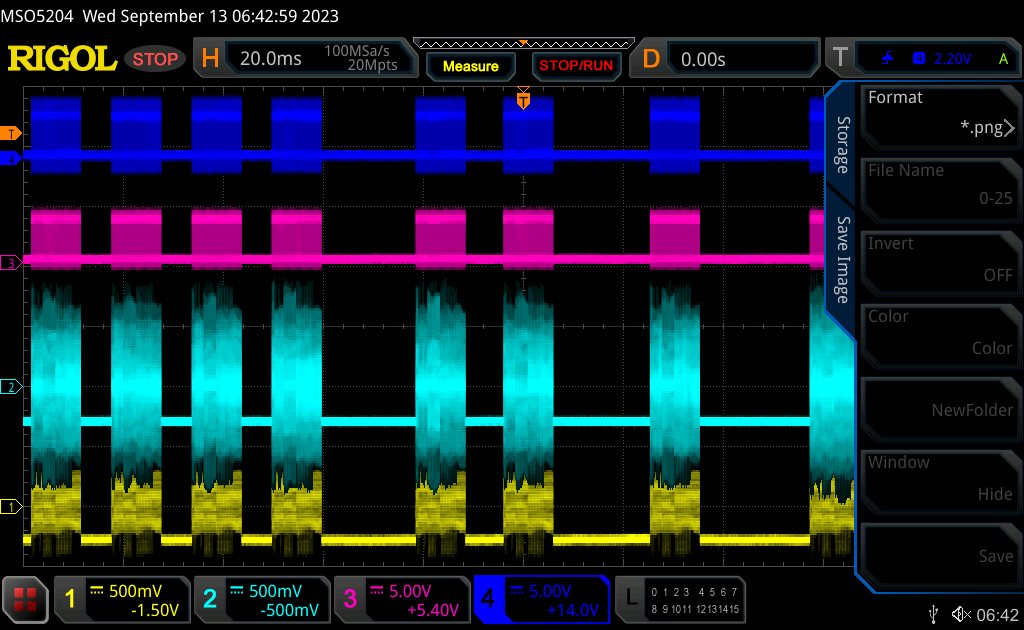

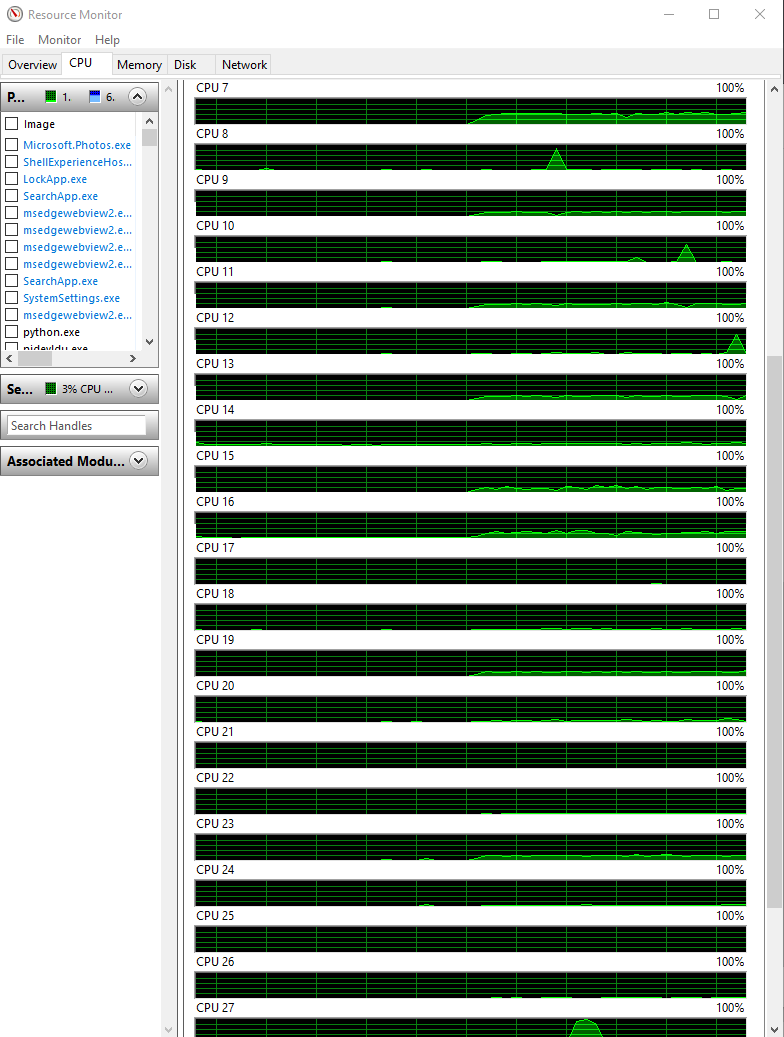 

In [47]:
ni_streamer.stream_exp(nreps=2000)

In [48]:
ni_streamer.reset_all()